### map -- home and work locations

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import json
import geopandas as gpd
from copy import deepcopy
import shapely
from shapely.geometry import Point,Polygon,LineString
import pyproj

import contextily as ctx

### data prep

In [3]:
# follower network -- data
edgelist = pd.read_csv('../data/usageousers_city_follower_networks.rpt.gz')
edgelist = edgelist.loc[edgelist['cbsacode'] == 14460.0]  # Boston only
# edgelist = edgelist.loc[edgelist['cbsacode'] == 35620.0]  # New York

# read in data about individuals -- data2
userinfo = pd.read_csv('../data/usageousers_data_export_with_tract_geoid_top50.csv.gz', index_col=0)
user_geo = userinfo.loc[:,["user_id", "lat_home", "lon_home", "lat_work", "lon_work"]]

In [4]:
# edgelist with geoinfo
edgelist = pd.merge(pd.merge(edgelist, user_geo, left_on="user_id1", right_on="user_id", how="left"),\
               user_geo, left_on="user_id2", right_on="user_id", how="left", suffixes=("1", "2"))

# remove duplicate columns
edgelist = edgelist.loc[:,~edgelist.columns.duplicated()]

### single user
user_id == 963481 (as an example)

In [5]:
# select a focal user
focal_user = edgelist[edgelist["user_id1"]==963481] # from Boston
# focal_user = edgelist[edgelist["user_id1"]==12912] # from New York

focal_user = focal_user[focal_user['lat_home2'] < 42.9]

In [6]:
# point of home
point_home = focal_user[['lon_home1', 'lat_home1']].drop_duplicates()
point_home['focal_home'] = point_home.apply(lambda row: Point(row['lon_home1'], row['lat_home1']), axis = 1)
point_home = point_home.set_geometry('focal_home')

# projection change
point_home.crs = {'init': 'epsg:4326'}
point_home = point_home.to_crs({'init': 'epsg:3857'})

In [7]:
# point of work
point_work = focal_user[['lon_work1', 'lat_work1']].drop_duplicates()
point_work['focal_work'] = point_work.apply(lambda row: Point(row['lon_work1'], row['lat_work1']), axis = 1)
point_work = point_work.set_geometry('focal_work')

# projection change
point_work.crs = {'init': 'epsg:4326'}
point_work = point_work.to_crs({'init': 'epsg:3857'})

In [8]:
# create geodataframe with lines = edges between home locations
lines_home = deepcopy(focal_user)
lines_home['geometry_home_edges'] = lines_home.apply(lambda row: LineString([(row['lon_home1'], row['lat_home1']), (row['lon_home2'], row['lat_home2'])]),axis = 1)
lines_home = gpd.GeoDataFrame(lines_home).set_geometry('geometry_home_edges')

# projection change
lines_home.crs = {'init': 'epsg:4326'}
lines_home = lines_home.to_crs({'init': 'epsg:3857'})

In [9]:
# create geodataframe with lines = edges between work locations
lines_work = deepcopy(focal_user)
lines_work['geometry_work_edges'] = lines_work.apply(lambda row: LineString([(row['lon_work1'], row['lat_work1']), (row['lon_work2'], row['lat_work2'])]),axis = 1)
lines_work = gpd.GeoDataFrame(lines_work).set_geometry('geometry_work_edges')

# projection change
lines_work.crs = {'init': 'epsg:4326'}
lines_work = lines_work.to_crs({'init': 'epsg:3857'})

In [10]:
# point of friends
friend_homes = lines_home[['lon_home2', 'lat_home2']]
friend_homes['geometry_friend_home'] = friend_homes.apply(lambda row: Point(row['lon_home2'], row['lat_home2']), axis = 1)
friend_homes = friend_homes.set_geometry('geometry_friend_home')

# projection change
friend_homes.crs = {'init': 'epsg:4326'}
friend_homes = friend_homes.to_crs({'init': 'epsg:3857'})

# get geometry for friends -- work
friend_works = lines_work[['lon_work2', 'lat_work2']]
friend_works['geometry_friend_work'] = friend_works.apply(lambda row: Point(row['lon_work2'], row['lat_work2']), axis = 1)
friend_works = friend_works.set_geometry('geometry_friend_work')

# projection change
friend_works.crs = {'init': 'epsg:4326'}
friend_works = friend_works.to_crs({'init': 'epsg:3857'})

In [11]:
# list of friends
friends = set(list(focal_user['user_id2']))

# third ties
friend_table = edgelist[(edgelist['user_id1'].isin(friends)) & (edgelist['user_id2'].isin(friends))]
friend_table['geometry_third'] = friend_table.apply(lambda row: LineString([(row['lon_home1'], row['lat_home1']), (row['lon_home2'], row['lat_home2'])]),axis = 1)
friend_table = gpd.GeoDataFrame(friend_table).set_geometry('geometry_third')

# projection change
friend_table.crs = {'init': 'epsg:4326'}
friend_table = friend_table.to_crs({'init': 'epsg:3857'})

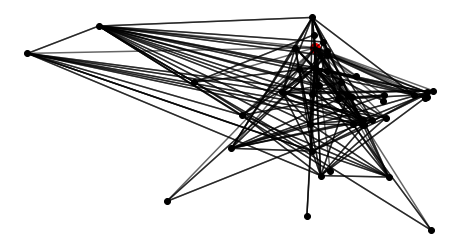

In [12]:
# plot
f, ax = plt.subplots(1, figsize=(8,8))

# home point
point_home.plot(ax=ax, color='red', markersize=100)

# edges
lines_home.plot(ax=ax, alpha=0.6, color='black')
friend_table.plot(ax=ax, alpha=0.6, color='black')

# homes of friends
friend_homes.plot(ax=ax, color='black')

# works of friends
# friend_works.plot(ax=ax, color='blue')
# work point
# point_work.plot(ax=ax, color='blue', markersize=100)


ax.set_axis_off()
plt.show()

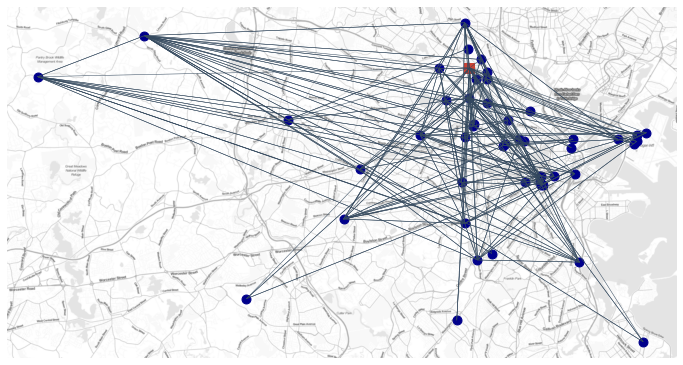

In [23]:
# plot
f, ax = plt.subplots(1, figsize=(12,7))

# home point
point_home.plot(ax=ax, color='#CB4335', marker='s', markersize=120)

# edges
lines_home.plot(ax=ax, color='#34495E', linewidth=0.5)
friend_table.plot(ax=ax, color='#34495E', linewidth=0.5)

# homes of friends
fp = friend_homes.plot(ax=ax, color='darkblue', markersize=80)
ctx.add_basemap(fp, url=ctx.providers.Stamen.TonerLite, alpha=0.7, attribution=False)
ax.set_axis_off()

# plt.show()
plt.savefig("../fig/single_user_example.png", dpi=500, bbox_inches='tight')

In [101]:
# test user from New York ?
# follower network -- data
edgelist = pd.read_csv('../data/usageousers_city_follower_networks.rpt.gz')
edgelist = edgelist.loc[edgelist['cbsacode'] == 35620.0]  # New York

# read in data about individuals -- data2
userinfo = pd.read_csv('../data/usageousers_data_export_with_tract_geoid_top50.csv.gz', index_col=0)
user_geo = userinfo.loc[:,["user_id", "lat_home", "lon_home", "lat_work", "lon_work"]]

In [102]:
# edgelist with geoinfo
edgelist = pd.merge(pd.merge(edgelist, user_geo, left_on="user_id1", right_on="user_id", how="left"),\
               user_geo, left_on="user_id2", right_on="user_id", how="left", suffixes=("1", "2"))

# remove duplicate columns
edgelist = edgelist.loc[:,~edgelist.columns.duplicated()]

In [103]:
edgelist.head(2)

,cbsacode,user_id1,user_id2,lat_home1,lon_home1,lat_work1,lon_work1,lat_home2,lon_home2,lat_work2,lon_work2
0,35620,4558,47,40.724,-73.995,40.724,-73.995,40.717,-73.956,40.701,-73.988
1,35620,8286,47,40.803,-73.946,40.746,-73.993,40.717,-73.956,40.701,-73.988


In [122]:
test = edgelist.groupby('user_id1')['user_id2'].agg('count').reset_index()
test = test[(test['user_id2']>19) & (test['user_id2']<51)]
test[6:20]

,user_id1,user_id2
34,11752,31
39,12912,41
47,30393,50
55,43693,31
63,73653,30
73,350373,24
74,355203,42
85,629193,41
86,630613,26
99,669533,27


In [195]:
# edgelist[edgelist['user_id1']==12912]

In [7]:
# load census data
census = pd.read_csv('../data/censusdata_top50_2012.csv') 

In [8]:
census.head()

,state,county,tract,population,population_error,education_bachelor,education_bachelor_error,education_total,education_total_error,income,...,race_total,race_total_error,white,white_error,black,black_error,native,native_error,asian,asian_error
0,34,3,1000,6549,22,1689,271,4197,137,55598.0,...,6549,22,5685,240,150,126,0,17,642,280
1,34,3,2100,2006,164,584,102,1465,116,100874.0,...,2006,164,1418,176,27,30,5,7,529,131
2,34,3,2200,5151,139,930,225,3638,175,36357.0,...,5151,139,3820,257,48,44,0,17,1213,198
3,34,3,2300,5729,26,1343,210,3939,176,37859.0,...,5729,26,3793,395,107,96,0,17,1773,345
4,34,3,3100,5068,303,940,163,3677,230,34507.0,...,5068,303,2483,386,457,217,0,17,1198,224


In [5]:
# function to create tract geoids
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract

census['geoid'] = census.apply(create_geoid,axis=1)
census = pd.merge(census,names, on='geoid')

# geojson data, converted to geopandas dataframe
tract_geoms = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/censustract_geoms_top50.geojson').readlines()]
)

# projections
init_crs = 4326 # lon,lat
project_crs = 3857 # Cartesian systems

# possibly projecting census tract geometries into the same Cartesian coordinate system as the user coordinates would work like
tract_geoms.crs = {'init': 'epsg:' + str(init_crs)}
#tract_geoms.to_crs(epsg = project_crs, inplace=True)

# creating spatial index
tract_si = tract_geoms.sindex

/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
# merge geometries of tracts with census data 

# - merge here is too complicated

new_columns = tract_geoms.columns.values
new_columns[4] = 'geoid' 
tract_geoms.columns  = new_columns

merged = pd.merge(tract_geoms, census, on='geoid')

In [10]:
merged.head()

,geometry,aland,awater,display_name,geoid,population_x,simple_name,sumlevel,state,county,...,black,black_error,native,native_error,asian,asian_error,cbsacode_x,short_name_x,cbsacode_y,short_name_y
0,"POLYGON ((-70.87373 42.51921, -70.85809 42.527...",2391067,4378783,"Census Tract 2033.02, Essex, MA",14000US25009203302,4598,Census Tract 2033.02,140,25,9,...,27,41,0,12,17,22,14460.0,Boston,14460.0,Boston
1,"POLYGON ((-70.63999 42.63502, -70.63968 42.636...",9739625,3758684,"Census Tract 2201.01, Essex, MA",14000US25009220101,4172,Census Tract 2201.01,140,25,9,...,0,12,10,16,0,12,14460.0,Boston,14460.0,Boston
2,"POLYGON ((-70.93399 42.49080, -70.90654 42.484...",2919051,24048,"Census Tract 2021.02, Essex, MA",14000US25009202102,6264,Census Tract 2021.02,140,25,9,...,120,88,0,17,68,76,14460.0,Boston,14460.0,Boston
3,"POLYGON ((-70.91991 42.62515, -70.91957 42.625...",15801377,878721,"Census Tract 2151.02, Essex, MA",14000US25009215102,3122,Census Tract 2151.02,140,25,9,...,0,12,0,12,0,12,14460.0,Boston,14460.0,Boston
4,"POLYGON ((-70.64380 42.66607, -70.64065 42.685...",8358411,417536,"Census Tract 2201.02, Essex, MA",14000US25009220102,2995,Census Tract 2201.02,140,25,9,...,97,153,0,12,9,20,14460.0,Boston,14460.0,Boston


In [6]:
#read in data about individuals: position, nr of tweets from home, work, distance travelled etc. and filter on Boston
data2 = pd.read_csv('../data/usageousers_top50_common_data.csv.gz')
data2 = data2.loc[data2['cbsacode'] == 14460.0]

In [7]:
#merge with follower network
new_columns = data2.columns.values  
new_columns[1] = 'user_id1' 
data2.columns  = new_columns
m = pd.merge(data, data2[['user_id1','lat_home', 'lon_home','lat_work', 'lon_work', 'distance']], 'left', on = 'user_id1')
data2 = pd.read_csv('../data/usageousers_top50_common_data.csv.gz')
data2=data2.loc[data2['cbsacode'] == 14460.0]
new_columns[1] = 'user_id2' 
data2.columns  = new_columns
m2 = pd.merge(m, data2[['user_id2','lat_home', 'lon_home','lat_work', 'lon_work', 'distance']], 'left', on = 'user_id2')

In [8]:
#function to create shapely line from edges
def togeom(a,b,c,d):
    return LineString([(a,b),(c,d)])

In [9]:
m2.head()

,cbsacode,user_id1,user_id2,lat_home_x,lon_home_x,lat_work_x,lon_work_x,distance_x,lat_home_y,lon_home_y,lat_work_y,lon_work_y,distance_y
0,14460,4678,364,42.421,-71.126,42.451,-71.139,3.48,42.369,-71.154,42.369,-71.154,0.0
1,14460,5212,364,42.386,-71.123,42.368,-71.093,3.22,42.369,-71.154,42.369,-71.154,0.0
2,14460,794111,364,42.346,-71.077,42.369,-71.077,2.58,42.369,-71.154,42.369,-71.154,0.0
3,14460,896221,364,42.347,-71.128,42.347,-71.128,0.00,42.369,-71.154,42.369,-71.154,0.0
4,14460,963481,364,42.400,-71.123,42.355,-71.076,6.32,42.369,-71.154,42.369,-71.154,0.0


In [10]:
#create geodataframe with lines = edges between home locations
m2lines_h = deepcopy(m2)
m2lines_h['geometry'] = m2lines_h.apply(lambda row: togeom(row['lon_home_x'], row['lat_home_x'],row['lon_home_y'], row['lat_home_y']),axis = 1)
m2lines_h = GeoDataFrame(m2lines_h)

In [11]:
#create geodataframe with lines = edges between work locations
m2lines_w = deepcopy(m2)
m2lines_w['geometry'] = m2lines_w.apply(lambda row: togeom(row['lon_work_x'], row['lat_work_x'],row['lon_work_y'], row['lat_work_y']),axis = 1)
m2lines_w = GeoDataFrame(m2lines_w)

### Colormap based on poor / rich

In [12]:
#rich = above 70th percentile, poor = below 30th percentile
richb = census['income'].quantile(0.7)
poorb = census['income'].quantile(0.3)

#create colormap 2 = rich, 1 = in between, 0 = poor
mergedcolor = deepcopy(merged)
mergedcolor['income group'] = ''
for row in range(len(mergedcolor)):
    if mergedcolor['income'].loc[row] > richb:
        mergedcolor['income group'].loc[row] = 'rich'
    elif mergedcolor['income'].loc[row] < poorb:
        mergedcolor['income group'].loc[row] = 'poor'
    else:
        mergedcolor['income group'].loc[row] = 'in_between'

C:\Users\T440s\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Colormap based on 10 income groups

In [13]:
#define deciles
deciles = np.linspace(0.1,0.9,9)

#create income groups based on deciles
igroups=[census['income'].quantile(decile) for decile in deciles]

#create colormap
mergedcolor2 = deepcopy(merged)
mergedcolor2['income group'] = ''

for row in range(len(mergedcolor2)):
    if mergedcolor2['income'].loc[row] < igroups[0]:
        mergedcolor2['income group'].loc[row] = 0                         
    elif mergedcolor2['income'].loc[row] > igroups[8]: 
        mergedcolor2['income group'].loc[row] = 9
        
for row in range(len(mergedcolor2)):          
    for col in range(0,8):
        if igroups[col] < mergedcolor2['income'].loc[row] < igroups[col+1]:
                mergedcolor2['income group'].loc[row] = col+1  

In [14]:
#function returning a shapely point object from e.g. two coordinates
def togeom2(a,b):
    return Point(a,b)

In [15]:
#get home locations as geometry
m2['geometry'] = m2.apply(lambda row: togeom2(row['lon_home_x'], row['lat_home_x']), axis = 1)

### Prepare attributes for visualization

### Home

In [16]:
#get geometry column with home node of ego 
m2lines_h['geometry2'] = m2lines_h.apply(lambda row: togeom2(row['lon_home_x'], row['lat_home_x']), axis = 1)

#get second geometry column with home nodes of friends 
m2lines_h['geometry3'] = m2lines_h.apply(lambda row: togeom2(row['lon_home_y'], row['lat_home_y']), axis = 1)

In [17]:
#convert geometry2 and geometry3 column to Cartesian crs
m2lines_h = m2lines_h.set_geometry('geometry2')
m2lines_h.crs = {'init': 'epsg:4326'}
m2lines_h = m2lines_h.to_crs({'init': 'epsg:3857'})
m2lines_h = m2lines_h.set_geometry('geometry3')
m2lines_h.crs = {'init': 'epsg:4326'}
m2lines_h = m2lines_h.to_crs({'init': 'epsg:3857'})
m2lines_h = m2lines_h.set_geometry('geometry')

#Calculate distance of workplaces between ego and friends and put it in column 
m2lines_h['dist_from_friend_h'] = m2lines_h['geometry2'].distance(m2lines_h['geometry3'])

In [18]:
#filter on those working inside 5km
m43b = m2lines_h.loc[m2lines_h['dist_from_friend_h'] < 5000] 

In [19]:
#convert it back to lon, lat
m43b = m43b.set_geometry('geometry2')
m43b = m43b.to_crs({'init': 'epsg:4326'})
m43b = m43b.set_geometry('geometry3')
m43b = m43b.to_crs({'init': 'epsg:4326'})

### Work

In [20]:
#get geometry column with work node of ego 
m2lines_w['geometry2'] = m2lines_w.apply(lambda row: togeom2(row['lon_work_x'], row['lat_work_x']), axis = 1)

#get second geometry column with work nodes of friends 
m2lines_w['geometry3'] = m2lines_w.apply(lambda row: togeom2(row['lon_work_y'], row['lat_work_y']), axis = 1)

In [21]:
#convert geometry2 and geometry3 column to Cartesian crs
m2lines_w = m2lines_w.set_geometry('geometry2')
m2lines_w.crs = {'init': 'epsg:4326'}
m2lines_w = m2lines_w.to_crs({'init': 'epsg:3857'})
m2lines_w = m2lines_w.set_geometry('geometry3')
m2lines_w.crs = {'init': 'epsg:4326'}
m2lines_w = m2lines_w.to_crs({'init': 'epsg:3857'})
m2lines_w = m2lines_w.set_geometry('geometry')

#Calculate distance of workplaces between ego and friends and put it in column 
m2lines_w['dist_from_friend_w'] = m2lines_w['geometry2'].distance(m2lines_w['geometry3'])

In [22]:
#filter on those working inside 5km
m42b = m2lines_w.loc[m2lines_w['dist_from_friend_w'] < 5000] 

In [23]:
#convert it back to lon, lat
m42b = m42b.set_geometry('geometry2')
m42b = m42b.to_crs({'init': 'epsg:4326'})
m42b = m42b.set_geometry('geometry3')
m42b = m42b.to_crs({'init': 'epsg:4326'})
m42b = m42b.set_geometry('geometry')

### Function to return dataset for visualization of chosen individual

In [24]:
# function to plot when user_id given
def to_plot_h (x):
    m4 = m43b.loc[m43b['user_id1'] == x]
    return m4

def to_plot_w (x):
    m4b = m42b.loc[m42b['user_id1'] == x]
    return m4b

### Get individuals degrees inside 2 km to choose random ego for visualization

In [25]:
table5 = pd.read_csv('../data/deg_clust_2.csv', index_col = 0)

In [26]:
table5.head()

,user_id,degree_w,degree_h,clust_w,clust_h
0,5212,20,15,0.350459,0.000000
1,794111,9,3,0.677778,0.833333
2,963481,18,5,0.597110,0.000000
3,5480662,3,3,0.000000,0.000000
4,11097782,4,6,0.866667,0.400000


### Get concentric circles around home / workplace of ego

In [27]:
#function to get concentric circles around point
def circle (ego, radius):
    return ego.buffer(radius).boundary

In [28]:
m4b = to_plot_w(963481)

#get work location of ego in geometry column of work egonetwork and convert it to cartesian coordinate system
m4b = m4b.set_geometry('geometry2')
m4b.crs = {'init': 'epsg:4326'}
m4b = m4b.to_crs({'init': 'epsg:3857'})

#get the 0.5km circle arund ego's workplace
for x in range(500, 5500, 500):
    m4b['geometry' + str(x)] = m4b.apply(lambda row: circle(row['geometry2'],x), axis = 1)
    #convert back to lon, lat system
    m4b = m4b.set_geometry('geometry' + str(x))
    m4b.crs = {'init': 'epsg:3857'}
    m4b = m4b.to_crs({'init': 'epsg:4326'})

#convert geometry back to original
m4b = m4b.set_geometry('geometry2')
m4b.crs = {'init': 'epsg:3857'}
m4b = m4b.to_crs({'init': 'epsg:4326'})
m4b = m4b.set_geometry('geometry')

In [29]:
m4 = to_plot_h(963481)

#get work location of ego in geometry column of work egonetwork and convert it to cartesian coordinate system
m4 = m4.set_geometry('geometry2')
m4.crs = {'init': 'epsg:4326'}
m4 = m4.to_crs({'init': 'epsg:3857'})

#get the 0.5km circle arund ego's workplace
for x in range(500, 5500, 500):
    m4['geometry' + str(x)] = m4.apply(lambda row: circle(row['geometry2'],x), axis = 1)
    #convert back to lon, lat system
    m4 = m4.set_geometry('geometry' + str(x))
    m4.crs = {'init': 'epsg:3857'}
    m4 = m4.to_crs({'init': 'epsg:4326'})

#convert geometry back to original
m4 = m4.set_geometry('geometry2')
m4.crs = {'init': 'epsg:3857'}
m4 = m4.to_crs({'init': 'epsg:4326'})
m4 = m4.set_geometry('geometry')

###  Friends around work location

(42.284, 42.43)

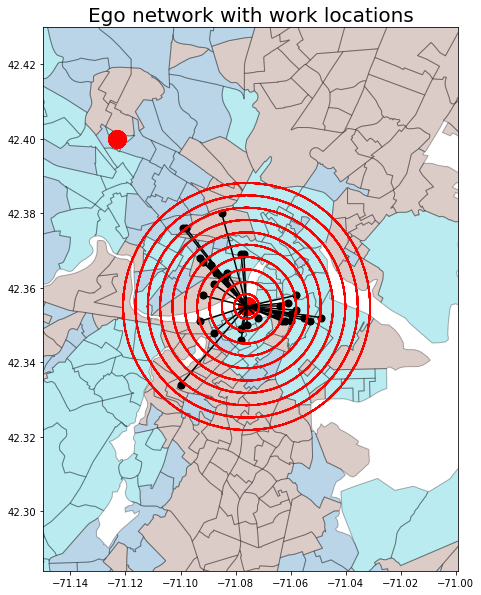

In [30]:
#background = tracts colored by poor, rich, in between
ax = mergedcolor.plot(column = 'income group', figsize = (10,10), edgecolor = 'black', alpha = 0.3)

#title
ax.set_title('Ego network with work locations', size = 20)

#ego network = black lines
m4b.plot(ax = ax, color = 'black')

#third edges - between friends = green lines
#d.plot(ax = ax, color = 'green')

#get work node of ego
m42b2 = m4b.set_geometry('geometry2')
m42b2.plot(ax = ax,color='red', markersize = 300)

#get work node of friends of ego inside 2kms
m42b3 = m4b.set_geometry('geometry3')
m42b3.plot(ax = ax, color = 'black', markersize = 50)

#get home node of ego
m43b2 = m4.set_geometry('geometry2')
m43b2.plot(ax = ax,color = 'red', markersize = 300)

#draw 2km circle around work location
for x in range(500, 5500, 500):
    m42b3 = m4b.set_geometry('geometry' + str(x))
    m42b3.plot(ax = ax,color = 'red')

#zoom in 
plt.xlim(min(m4b['lon_work_y'])-0.05, max(m4b['lon_work_y'])+0.05)
plt.ylim(min(m4b['lat_work_y'])-0.05, max(m4b['lat_work_y'])+0.05)

#save picture
#plt.savefig('../figures/worknet4.jpg')

### Friends around home location

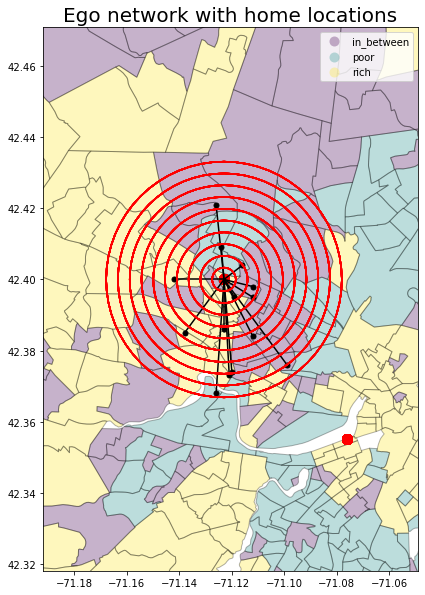

In [31]:
#background = tracts colored by poor, rich, in between
ax = mergedcolor.plot(column = 'income group', figsize = (10,10), edgecolor = 'black', alpha = 0.3, legend = True, cmap = 'viridis')

#title
ax.set_title('Ego network with home locations', size = 20)

#ego network = black lines
m4.plot(ax = ax, color = 'black')

#third edges - between friends = green lines
#d2.plot(ax = ax, color = 'green')

#get work node of ego
m42b2 = m4b.set_geometry('geometry2')
m42b2.plot(ax = ax,color='red', markersize = 100)

#get home node of friends of ego inside 2kms
m43b3 = m4.set_geometry('geometry3')
m43b3.plot(ax = ax, color = 'black', markersize = 25)

#get home node of ego
m43b2 = m4.set_geometry('geometry2')
m43b2.plot(ax = ax,color = 'red', markersize = 100)

#draw circles around home location
for x in range(500, 5500, 500):
    m43b4 = m4.set_geometry('geometry' + str(x))
    m43b4.plot(ax = ax,color = 'red')

#zoom in 
plt.xlim(min(m4['lon_home_y'])-0.05, max(m4['lon_home_y'])+0.05)
plt.ylim(min(m4['lat_home_y'])-0.05, max(m4['lat_home_y'])+0.05)
 
#save picture
#plt.savefig('../figures/homenet4.jpg')

### Comparison plot

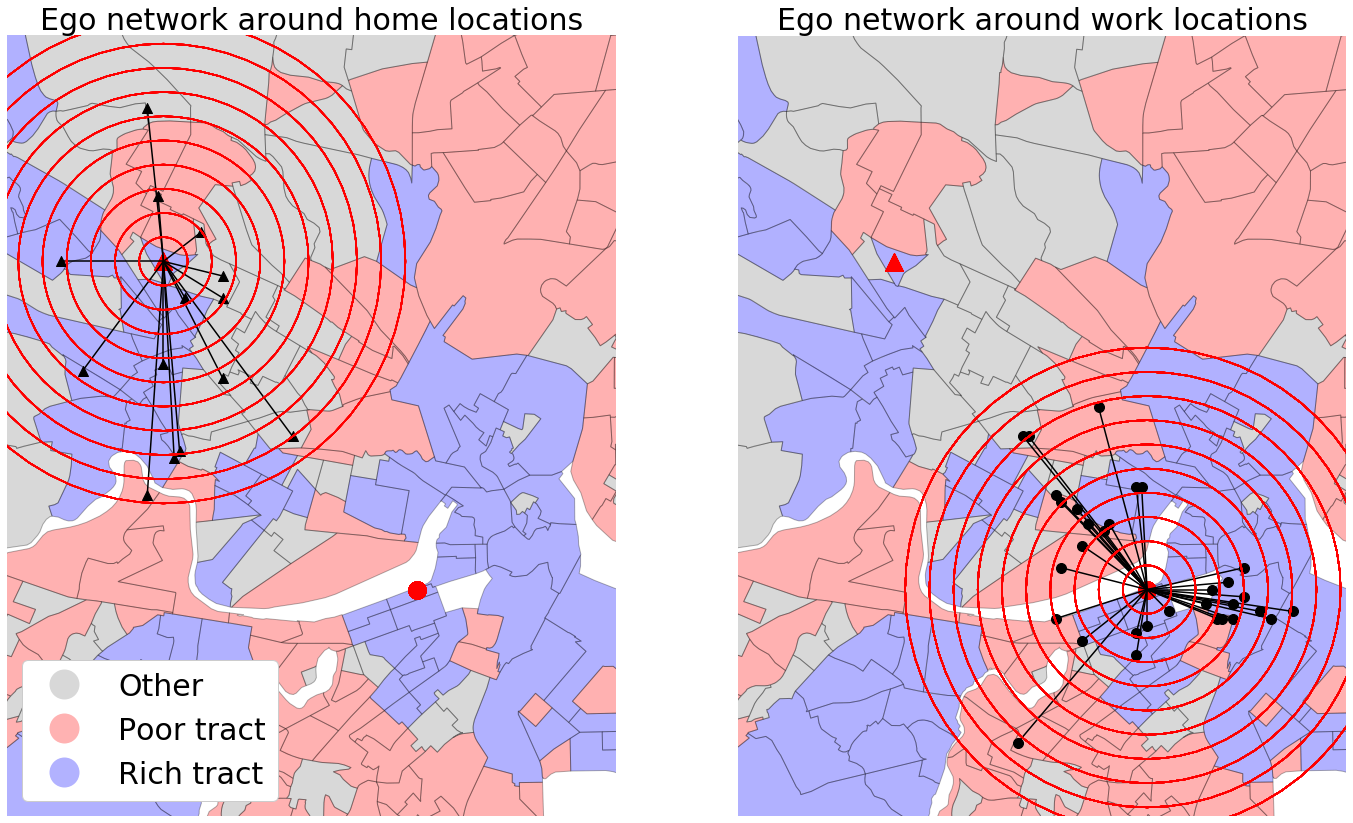

In [42]:
#get subplot
fig, ax = plt.subplots(1, 2, figsize = (24, 24), sharey = True)

#RIGHT = WORK PLOT

#background = tracts colored by poor, rich, in between
colorsList = [(0.5019607843137255, 0.5019607843137255, 0.5019607843137255),(1.0, 0.0, 0.0),(0.0, 0.0, 1.0)]
CustomCmap = matplotlib.colors.ListedColormap(colorsList)
mergedcolor.plot(ax = ax[1],column = 'income group',figsize = (20,20), edgecolor = 'black', alpha = 0.3, cmap = CustomCmap)

#title
ax[1].set_title('Ego network around work locations', size = 30)

#ego network = black lines
m4b.plot(ax = ax[1], color = 'black')

#get work node of ego
m42b2 = m4b.set_geometry('geometry2')
m42b2.plot(ax = ax[1],color='red', markersize = 300)

#get work node of friends of ego 
m42b3 = m4b.set_geometry('geometry3')
m42b3.plot(ax = ax[1], color = 'black', markersize = 100)

#get home node of ego
m43b2 = m4.set_geometry('geometry2')
m43b2.plot(ax = ax[1],color = 'red', markersize = 300, marker = "^")

#draw circles around work location
for x in range(500, 5500, 500):
    m42b4 = m4b.set_geometry('geometry' + str(x))
    m42b4.plot(ax = ax[1],color = 'red')

#zoom in 
ax[1].set_xlim(min(min(m4b['lon_work_y']),min(m4['lon_home_y']))-0.01,max(max(m4b['lon_work_y']),max(m4['lon_home_y']))+0.01)
ax[1].set_ylim(min(min(m4b['lat_work_y']),min(m4['lat_home_y']))-0.01,max(max(m4b['lat_work_y']),max(m4['lat_home_y']))+0.01)

#remove axis
ax[1].axis('off')

#LEFT = HOME PLOT

#background = tracts colored by poor, rich, in between
mergedcolor.plot(ax = ax[0], column = 'income group', figsize = (20,20), edgecolor = 'black', alpha = 0.3,cmap = CustomCmap, legend = True, legend_kwds = {'fontsize' : 30, 'loc':'lower left', 'markerscale': 3, 'handlelength': 2,'facecolor':'white', 'framealpha':1})

#customize legend
leg = ax[0].get_legend()
leg.get_texts()[0].set_text('Other')
leg.get_texts()[1].set_text('Poor tract')
leg.get_texts()[2].set_text('Rich tract')

#title
ax[0].set_title('Ego network around home locations', size = 30)

#ego network = black lines
m4.plot(ax = ax[0], color = 'black')

#get work node of ego
m42b2 = m4b.set_geometry('geometry2')
m42b2.plot(ax = ax[0],color='red', markersize = 300)

#get home node of friends of ego 
m43b3 = m4.set_geometry('geometry3')
m43b3.plot(ax = ax[0], color = 'black', markersize = 100, marker = "^")

#get home node of ego
m43b2 = m4.set_geometry('geometry2')
m43b2.plot(ax = ax[0],color = 'red', markersize = 300, marker = "^")

#draw circles around home location
for x in range(500, 5500, 500):
    m43b4 = m4.set_geometry('geometry' + str(x))
    m43b4.plot(ax = ax[0],color = 'red')

#zoom in 
ax[0].set_xlim(min(min(m4b['lon_work_y']),min(m4['lon_home_y']))-0.01,max(max(m4b['lon_work_y']),max(m4['lon_home_y']))+0.01)
ax[0].set_ylim(min(min(m4b['lat_work_y']),min(m4['lat_home_y']))-0.01,max(max(m4b['lat_work_y']),max(m4['lat_home_y']))+0.01)

#reomove axis
ax[0].axis('off')

#save picture
plt.savefig('../figures/comparison6b.jpg')

### Calculate the ratio of individuals on both graphs

In [35]:
len(set(m4['user_id2']) & set(m4b['user_id2'])) / len(list(m4['user_id2']) + list(set(list(m4b['user_id2'])) - set(list(m4['user_id2']))))

0.2777777777777778

In [36]:
lista3 = list(set(m4['user_id2']) & set(m4b['user_id2']))

### Plot indicating friends who both live near and work near ego's home and work locations

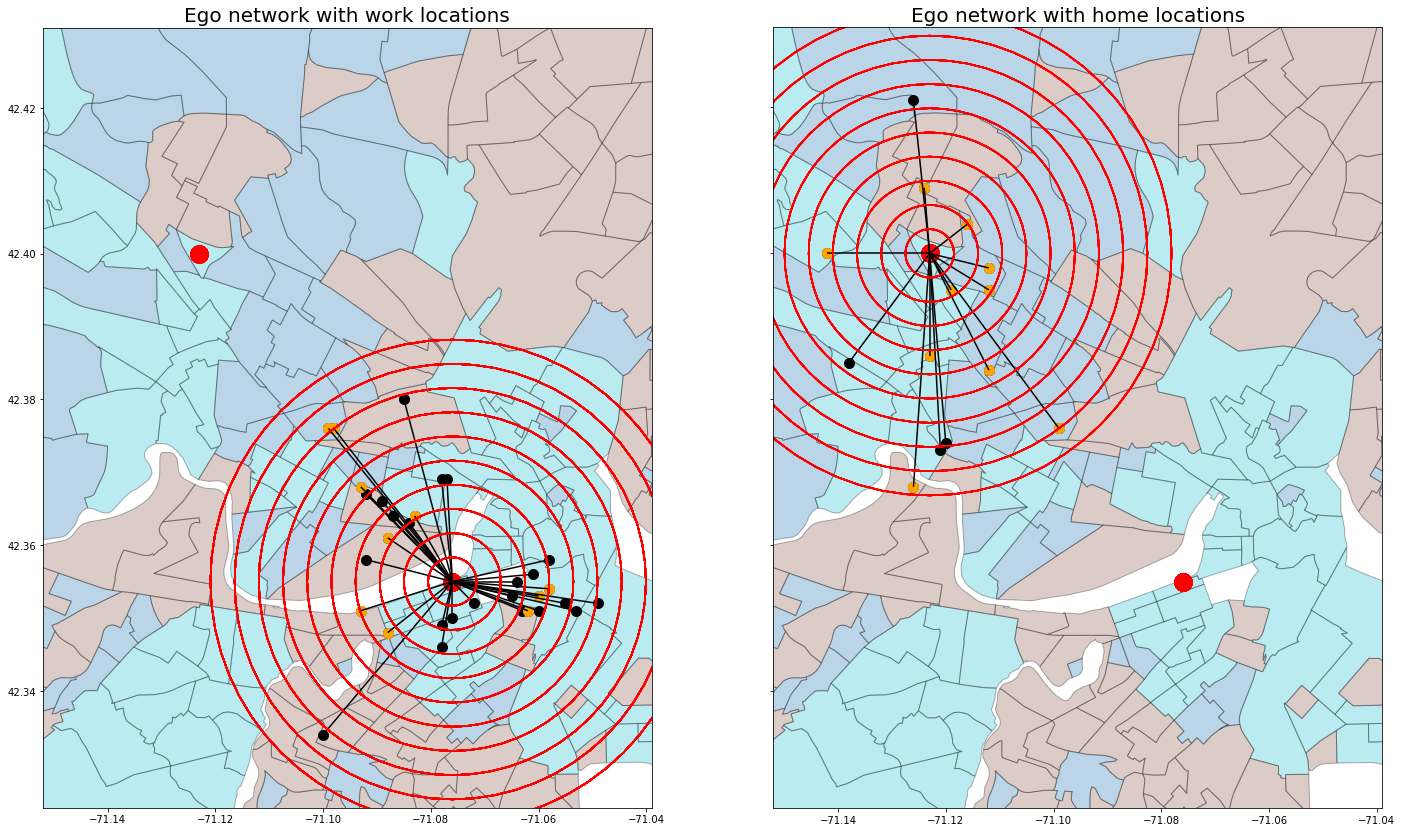

In [44]:
#get subplot
fig, ax = plt.subplots(1, 2, figsize = (24, 24), sharey = True)

#LEFT = WORK PLOT

#background = tracts colored by poor, rich, in between
mergedcolor.plot(ax = ax[0],column = 'income group',figsize = (20,20), edgecolor = 'black', alpha = 0.3)

#title
ax[0].set_title('Ego network with work locations', size = 20)

#ego network = black lines
m4b.plot(ax = ax[0], color = 'black')

#get work node of ego
m42b2 = m4b.set_geometry('geometry2')
m42b2.plot(ax = ax[0],color='red', markersize = 300)

#get work node of friends of ego 
m42b3 = m4b.set_geometry('geometry3')
m42b3.plot(ax = ax[0], color = 'black', markersize = 100)

#Get those friends who both live near ego and work near ego
lista3 = list(set(m4['user_id2']) & set(m4b['user_id2']))

#color these friends orange
m42b3b = m4b[m4b['user_id2'].isin(lista3)].set_geometry('geometry3')
m42b3b.plot(ax = ax[0], color = 'orange', markersize = 100)

#get home node of ego
m43b2 = m4.set_geometry('geometry2')
m43b2.plot(ax = ax[0],color = 'red', markersize = 300)

#draw circles around work location
for x in range(500, 5500, 500):
    m42b4 = m4b.set_geometry('geometry' + str(x))
    m42b4.plot(ax = ax[0],color = 'red')

#zoom in 
ax[0].set_xlim(min(min(m4b['lon_work_y']),min(m4['lon_home_y']))-0.01,max(max(m4b['lon_work_y']),max(m4['lon_home_y']))+0.01)
ax[0].set_ylim(min(min(m4b['lat_work_y']),min(m4['lat_home_y']))-0.01,max(max(m4b['lat_work_y']),max(m4['lat_home_y']))+0.01)

#RIGHT = HOME PLOT

#background = tracts colored by poor, rich, in between
mergedcolor.plot(ax = ax[1], column = 'income group', figsize = (20,20), edgecolor = 'black', alpha = 0.3)

#title
ax[1].set_title('Ego network with home locations', size = 20)

#ego network = black lines
m4.plot(ax = ax[1], color = 'black')

#get work node of ego
m42b2 = m4b.set_geometry('geometry2')
m42b2.plot(ax = ax[1],color='red', markersize = 300)

#get home node of friends of ego 
m43b3 = m4.set_geometry('geometry3')
m43b3.plot(ax = ax[1], color = 'black', markersize = 100)

#color orange those friends who are on both plots
m43b3b = m4[m4['user_id2'].isin(lista3)].set_geometry('geometry3')
m43b3b.plot(ax = ax[1], color = 'orange', markersize = 100)

#get home node of ego
m43b2 = m4.set_geometry('geometry2')
m43b2.plot(ax = ax[1],color = 'red', markersize = 300)

#draw circles around home location
for x in range(500, 5500, 500):
    m43b4 = m4.set_geometry('geometry' + str(x))
    m43b4.plot(ax = ax[1], color = 'red')

#zoom in 
ax[1].set_xlim(min(min(m4b['lon_work_y']),min(m4['lon_home_y']))-0.01,max(max(m4b['lon_work_y']),max(m4['lon_home_y']))+0.01)
ax[1].set_ylim(min(min(m4b['lat_work_y']),min(m4['lat_home_y']))-0.01,max(max(m4b['lat_work_y']),max(m4['lat_home_y']))+0.01)

#save picture
plt.savefig('../figures/comparison6.jpg')